In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load pre-processed data
Poore_GBM = pd.read_csv("Poore_GBM", index_col=0)
Poore_GBM

,f__Halomonadaceae; g__Cobetia,f__Thermoanaerobacteraceae; g__Ammonifex,f__Cryomorphaceae; g__Owenweeksia,f__Haloplasmataceae; g__Haloplasma,f__Desulfobacteraceae; g__Desulfosarcina,f__Enterobacteriaceae; g__Siccibacter,f__Acetobacteraceae; g__Asaia,f__Rhodobiaceae; g__Parvibaculum,g__Neosynechococcus,f__Sphingomonadaceae; g__Zymomonas,...,portion_weight,aliquot_concentration,analyte_A260A280Ratio,analyte_amount,analyte_type_label,radiation_therapy_code_label,radiation_therapy_site_label,radiation_therapy_type_label,year_of_diagnosis,vital_status_label
sample_id1,,,,,,,,,,,,,,,,,,,,,
s14192,0.893485,2.203858,1.674120,0.424344,1.372460,2.022902,1.464566,1.517857,1.734031,-0.420666,...,112.0,0.13,1.85,121.9,RNA,E843157C-27A8-4F36-8F07-96A24E8C9771,Primary Tumor Field,EXTERNAL BEAM,2002.0,Dead
s14168,0.180814,0.135872,-0.954348,0.682776,2.751091,-0.914354,1.512538,-1.407964,1.084384,-0.279578,...,NaN,0.16,1.90,20.0,DNA,NaN,NaN,NaN,2007.0,Dead
s14197,1.543645,2.854018,2.324280,1.074504,1.842048,2.673062,2.114726,2.168017,2.384191,0.229494,...,40.0,0.13,NaN,46.5,RNA,3A8D2E10-2AB1-40BA-A501-B0A56DADC35C,Primary Tumor Field,EXTERNAL BEAM,2002.0,Dead
s14161,0.997963,2.170523,1.664342,0.570449,-0.332872,2.024489,1.506755,1.549414,1.798506,-0.405216,...,122.0,0.15,1.80,219.7,RNA,E8425728-844D-46E5-9835-EAA9CB3A2EB1,Primary Tumor Field,EXTERNAL BEAM,2009.0,Alive
s14165,1.021629,2.180318,1.635810,0.419256,1.868306,1.907644,1.526159,1.553676,3.252892,-0.421363,...,34.0,0.15,1.80,52.6,RNA,45027352-CD80-448B-AC0F-4FD3173529DA,Primary Tumor Field,EXTERNAL BEAM,2010.0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s14113,1.125039,2.549325,2.202670,0.560846,1.890649,2.471937,2.116887,1.787414,1.931288,0.058256,...,70.0,0.15,1.90,98.4,RNA,8190E5D0-A3CA-4451-97DA-1619FC5C20FB,Primary Tumor Field,EXTERNAL BEAM,2007.0,Dead
s14107,2.359550,2.084960,1.555222,0.305446,-2.833901,1.904004,1.345668,1.398959,1.615133,-0.539564,...,NaN,0.17,1.81,123.6,RNA,7450C1EA-8F99-4CF1-9471-F3A344E73358,Primary Tumor Field,EXTERNAL BEAM,2008.0,Alive
s14080,0.657392,2.110302,1.562616,0.397289,2.176143,1.778996,1.338868,1.185277,1.730294,-0.824475,...,NaN,0.55,1.79,35.0,RNA,8E82EE4F-FE89-45DC-96EE-E68378F12A75,Primary Tumor Field,EXTERNAL BEAM,2005.0,Dead


In [3]:
class_counts = Poore_GBM['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           382
Blood Derived Normal     71
Recurrent Tumor          36
Name: count, dtype: int64


In [4]:
# Prepare features and target variable
X = Poore_GBM.drop(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled
y = Poore_GBM['sample_type']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))

Unique values of y: ['Blood Derived Normal' 'Primary Tumor' 'Recurrent Tumor']
Unique values of y: [0 1 2]


In [5]:
# Oversampling to ensure class balance
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)

(1146, 1273)
(1146,)


Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score: 0.9551242236024844
Test Set Accuracy: 0.9680232558139535


<Figure size 800x600 with 0 Axes>

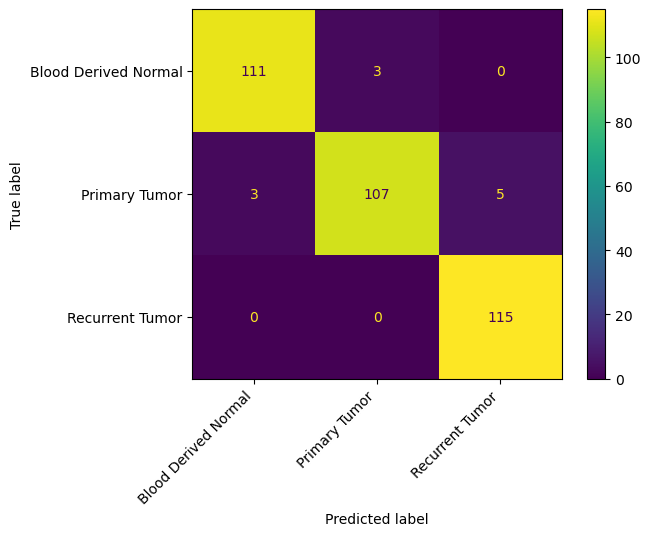

In [6]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', seed=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blood Derived Normal', 'Primary Tumor', 'Recurrent Tumor'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.xticks(rotation=45, ha='right')
plt.show()